<a href="https://colab.research.google.com/github/sarmi2325/Machine-Learning/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

img_size = (224, 224)
batch_size = 32
class_names = ['NORMAL', 'PNEUMONIA']
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir = "/content/drive/MyDrive/chest_xray/test"



In [25]:
def augment_images(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)    # Slight brightness change
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Slight contrast change
    return image, label




In [26]:
# Training dataset (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size ,
    batch_size=batch_size,
    label_mode='binary'
)
train_ds = train_ds.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
# Validation dataset (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size ,
    batch_size=batch_size,
    label_mode='binary'
)

# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size ,
    batch_size=batch_size,
    label_mode='binary'
)




Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


In [27]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Extract labels from all batches and flatten
train_labels = np.concatenate([y.numpy().flatten() for x, y in train_ds])

# Now compute class wei ghts
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.9061930783242258), 1: np.float64(0.6777849740932642)}


In [28]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# --- Compile model ---
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train top layers ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

# --- Fine-tuning: unfreeze last 20 layers ---
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)




Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 470ms/step - accuracy: 0.8213 - loss: 0.3358 - val_accuracy: 0.8996 - val_loss: 0.2584
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 338ms/step - accuracy: 0.9314 - loss: 0.1586 - val_accuracy: 0.9187 - val_loss: 0.2084
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 48s 365ms/step - accuracy: 0.9394 - loss: 0.1560 - val_accuracy: 0.9417 - val_loss: 0.1620
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 46s 348ms/step - accuracy: 0.9388 - loss: 0.1372 - val_accuracy: 0.9484 - val_loss: 0.1389
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 337ms/step - accuracy: 0.9520 - loss: 0.1151 - val_accuracy: 0.9350 - val_loss: 0.1863
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 490ms/step - accuracy: 0.8879 - loss: 0.2302 - val_accuracy: 0.9178 - val_loss: 0.1968
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 46s 354ms/step - accuracy: 0.9273 - loss: 0.1740 - val_accuracy: 0.9293 - val_loss: 0.1720
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 331ms/step - accuracy: 0.9272 - loss: 0.1513

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Confusion Matrix:
 [[159  75]
 [  9 381]]
              precision    recall  f1-score   support

      NORMAL       0.95      0.68      0.79       234
   PNEUMONIA       0.84      0.98      0.90       390

    accuracy           

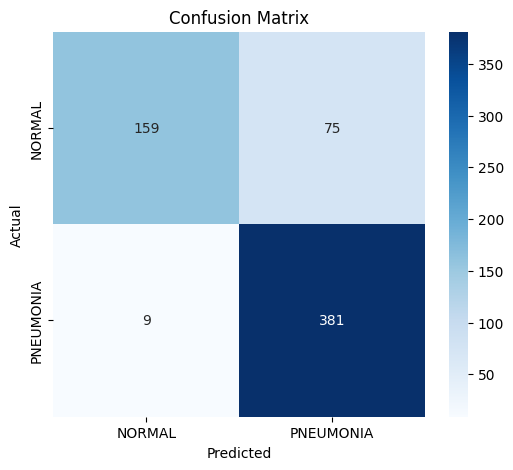

In [29]:
# --- Evaluation on test set ---
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Plot confusion matrix ---
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [30]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.8612 - loss: 0.3301
Test Accuracy: 0.8654
